In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Variants/Infected/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


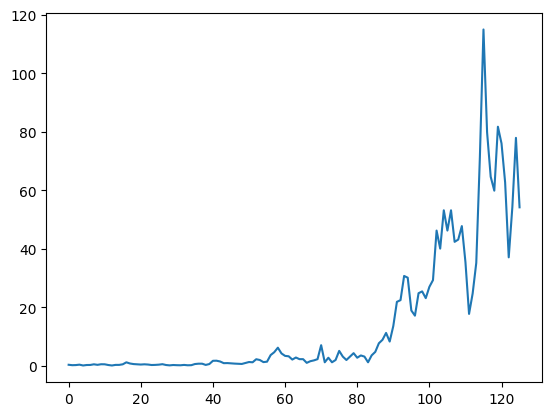

In [3]:
plt.plot(data['delta_variants'])

In [4]:
path = 'hyperparameter/Infected/delta/*.pkl'
files = glob.glob(path)
dic_hyperparameter = {}
for file in files:
    dic_hyperparameter[file[30:-4]] = load_hyperparameter(file)
    
dic_hyperparameter

{'BiGRU': [409, 1e-05, 20, 4, 64, 8, 0.25],
 'BiLSTM': [425, 0.001, 50, 8, 64, 32, 0.25],
 'BiRNN': [531, 1e-05, 50, 4, 32, 8, 0.25],
 'GRU': [454, 0.001, 50, 4, 64, 16, 0.25],
 'LSTM': [2111, 1e-05, 50, 2, 32, 8, 0.25],
 'RNN': [475, 0.001, 50, 1, 32, 8, 0.25],
 'seq2seq_BiGRU': [362,
  0.001,
  20,
  2,
  32,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiLSTM': [600,
  0.001,
  50,
  1,
  64,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiRNN': [503, 0.001, 50, 1, 32, 32, 0.25, MSELoss()],
 'seq2seq_GRU': [776,
  0.001,
  50,
  2,
  64,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_LSTM': [2764,
  0.0001,
  50,
  1,
  32,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_RNN': [486, 0.001, 50, 1, 64, 8, 0.25, MSELoss()]}

In [5]:
dic_model = load_model_multiple(dic_hyperparameter, 'Infected', 'delta')

In [7]:
df = Prepare_df.processing(data, 'stdDay', 'delta_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

predicted_values = {}
num_model = 0
for name, state in dic_model.items():
    batch_size = dic_hyperparameter[name][4]
    if num_model < 6:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 57, 60, 1, batch_size, 'mto')
        label_y, predicted = predict_mto(state, df, x_ss, y_ms)
        predicted_values[name] = [label_y, predicted]
    else:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 51, 60, 7, batch_size, 'mtm')
        label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 7, 0.5, device)
        predicted_values[name] = [label_y, predicted, first_label_y, first_predicted, all_predicted]
        
    
    num_model += 1

In [9]:
actual_data = predicted_values['RNN'][0]

13.224405003451478


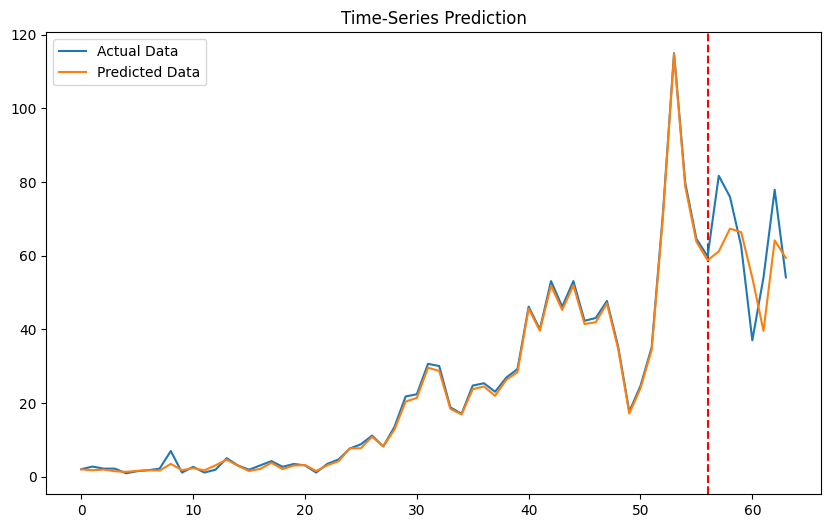

In [10]:
print(rmse(actual_data[-7:], predicted_values['RNN'][1][-7:]))
plotting(actual_data, predicted_values['RNN'][1], 56)

16.047489262220857


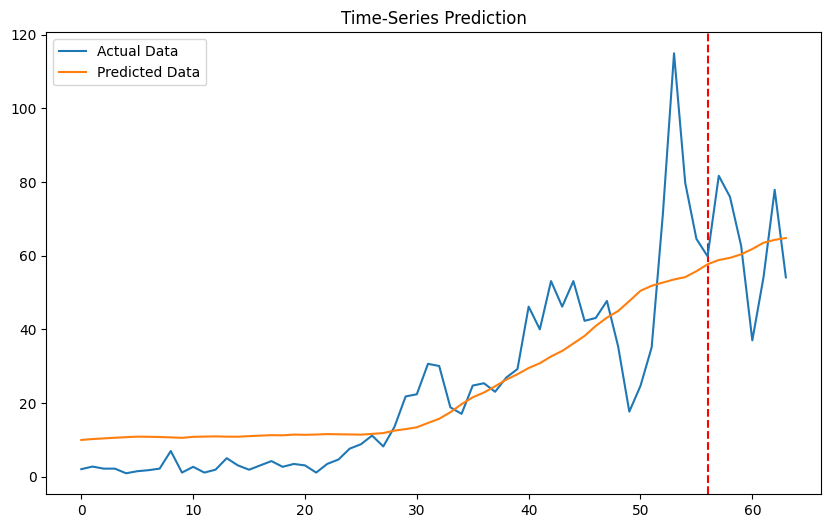

In [11]:
print(rmse(actual_data[-7:], predicted_values['LSTM'][1][-7:]))
plotting(actual_data, predicted_values['LSTM'][1], 56)

14.51531752146757


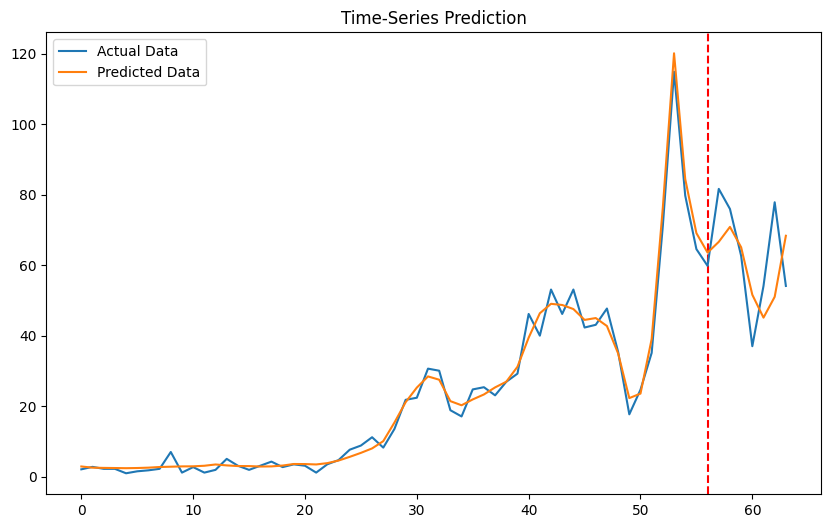

In [19]:
print(rmse(actual_data[-7:], predicted_values['GRU'][1][-7:]))
plotting(actual_data, predicted_values['GRU'][1], 56)

19.611630690730674


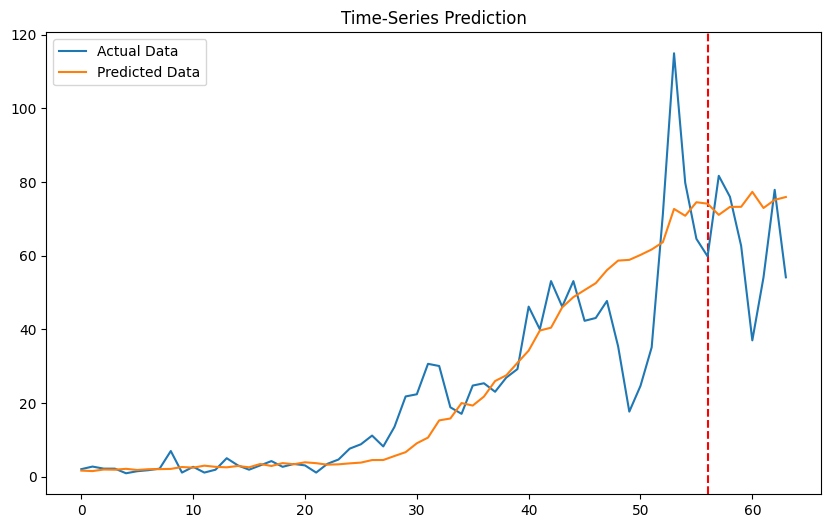

In [18]:
print(rmse(actual_data[-7:], predicted_values['BiRNN'][1][-7:]))
plotting(actual_data, predicted_values['BiRNN'][1], 56)

14.823295940480394


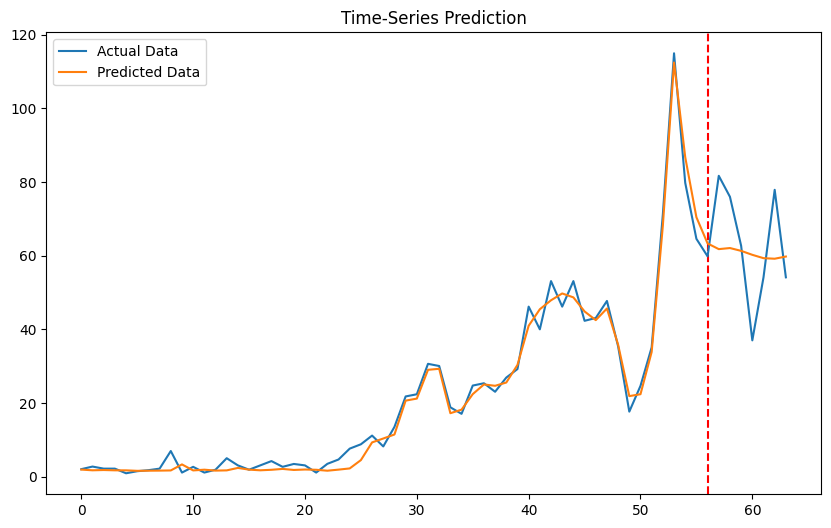

In [20]:
print(rmse(actual_data[-7:], predicted_values['BiLSTM'][1][-7:]))
plotting(actual_data, predicted_values['BiLSTM'][1], 56)

15.598206030568718


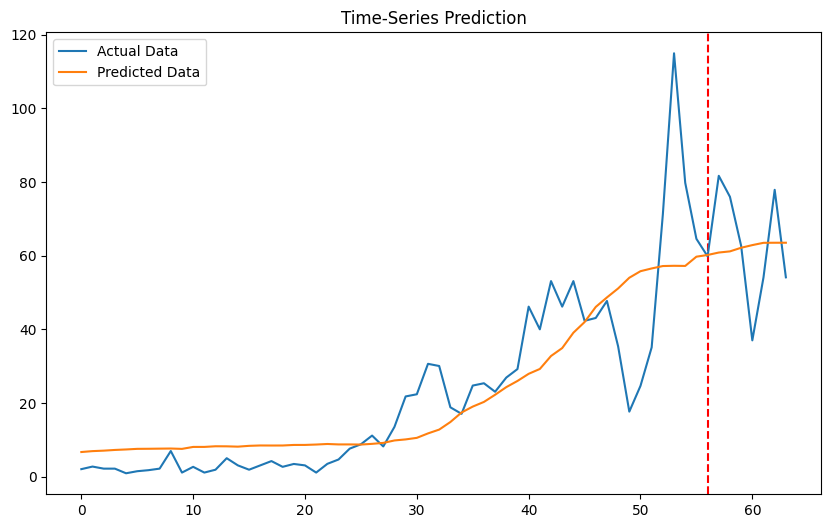

In [21]:
print(rmse(actual_data[-7:], predicted_values['BiGRU'][1][-7:]))
plotting(actual_data, predicted_values['BiGRU'][1], 56)

15.502329989631297


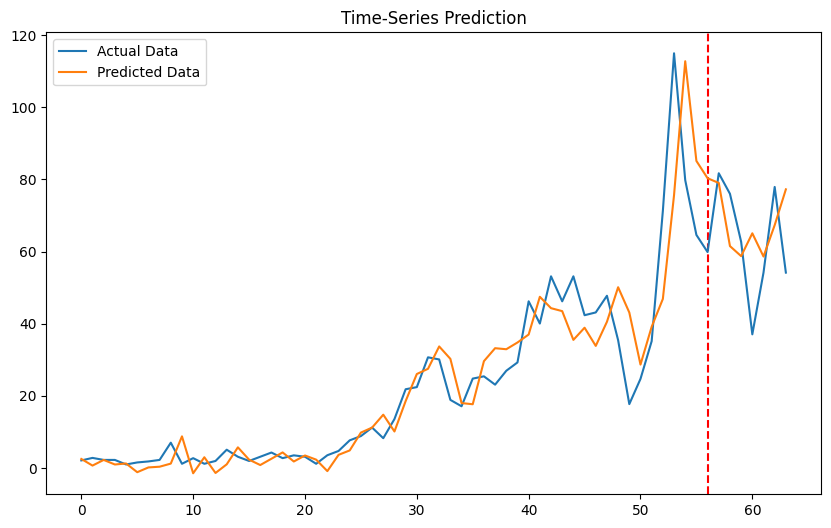

In [22]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_RNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_RNN'][4], 56)

17.12449478183818


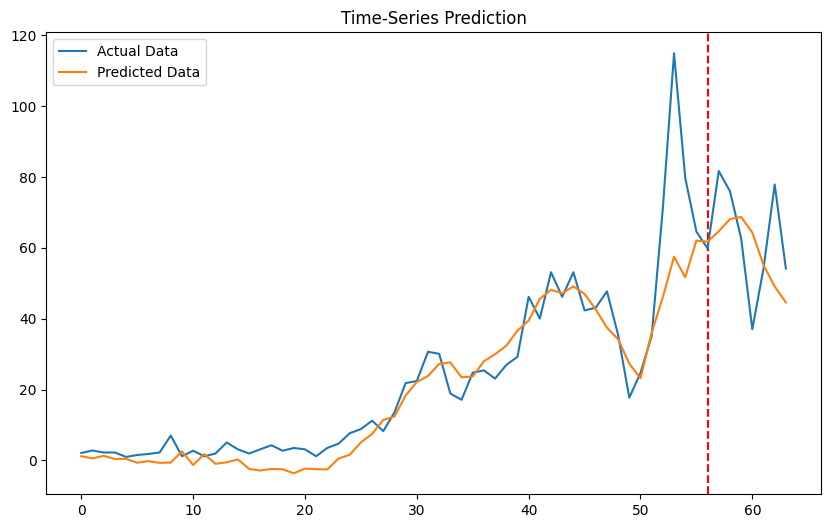

In [23]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_LSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_LSTM'][4], 56)

23.64776128451764


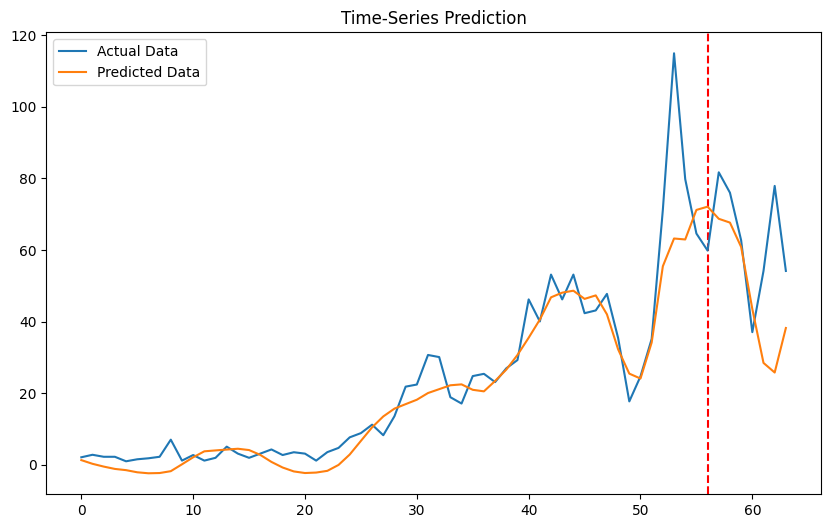

In [24]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_GRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_GRU'][4], 56)

26.312085943520685


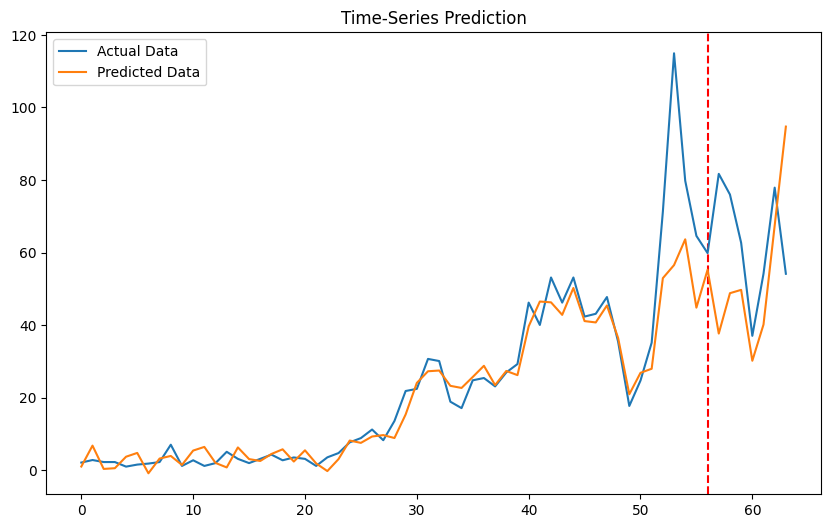

In [25]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiRNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiRNN'][4], 56)

24.628174862752466


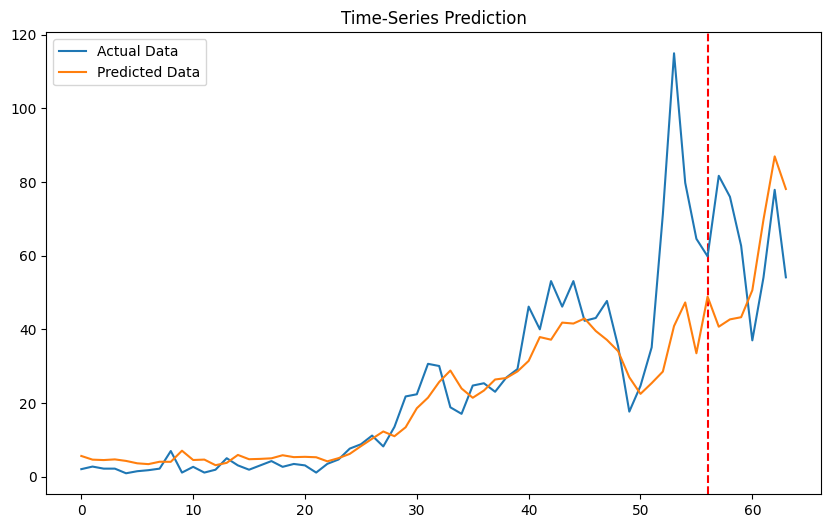

In [26]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiLSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiLSTM'][4], 56)

25.70310125378842


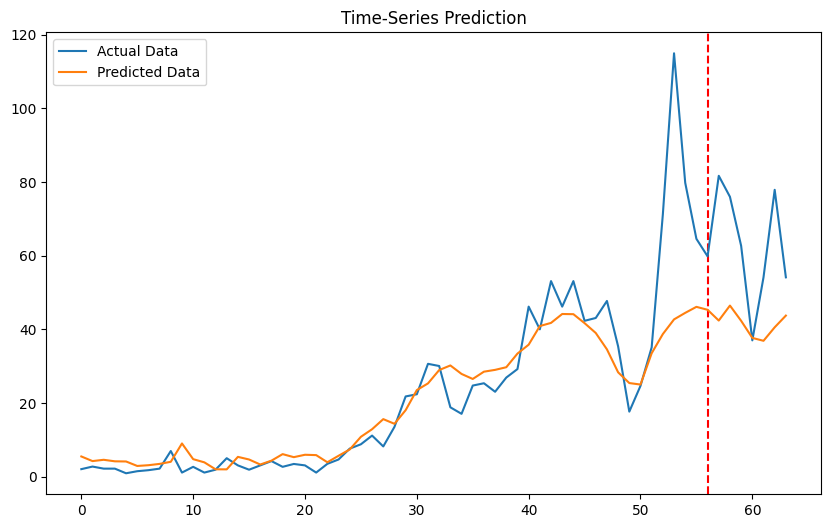

In [27]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiGRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiGRU'][4], 56)

In [28]:
best_model = 'RNN'
datetime_index = data['stdDay'][-1*len(actual_data):]
df_predicted = pd.DataFrame()
df_predicted = pd.DataFrame(np.concatenate([actual_data, predicted_values[best_model][1]], axis = 1), 
                            index = datetime_index, 
                            columns = ['Delta_origin', 'Delta_Predicted'])

df_predicted.to_csv(f'Data/Predicted/Variants/Infected/delta_{best_model}.csv')

In [29]:
df_predicted

,Delta_origin,Delta_Predicted
stdDay,,
2021-06-13,2.100000,2.047840
2021-06-14,2.800000,1.798729
2021-06-15,2.240000,1.986737
2021-06-16,2.240000,1.529873
2021-06-17,0.980000,1.370238
...,...,...
2021-08-11,62.700001,66.417740
2021-08-12,37.049999,54.029575
2021-08-13,54.150002,39.630505
